# Image Classification on CIFAR10 with active learning

### Imports

In [1]:
import torch
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

### Create model architecture

In [2]:
class Net(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# # We could also load pretrained models from torchvision
# For example:
# from torchvision import models
# model = models.resnet18(pretrained=True)
# model = models.mobilenet_v2(pretrained=True)

### Load the CIFAR10 dataset

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load training dataset and create subset for initial "labeled" set
full_dataset = torchvision.datasets.CIFAR10(root='data', train=True, transform=transform, download=True)
print(len(full_dataset))

init_indices = list(range(2000)) # indices for initial our "labeled" set
labeled_set = Subset(full_dataset, init_indices)
# Data loader
labeled_loader = DataLoader(labeled_set, batch_size=64)

Files already downloaded and verified
50000


### Model Initialization

In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
model = Net(n_classes=len(classes))

### Visualize our dataset

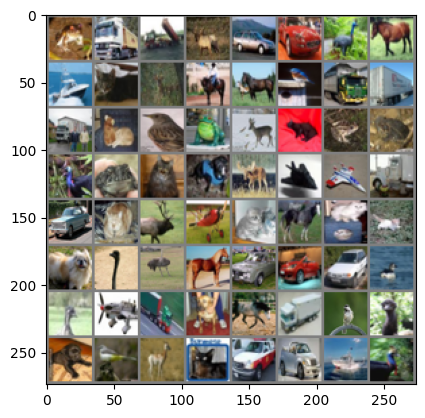

frog  truck truck deer  car  


In [5]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(labeled_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print 5 first labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(5)))

### Training on "labeled" dataset

In [6]:
def train(model, data_loader, epochs = 100):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

  for epoch in range(epochs):  # loop over the dataset multiple times
      running_loss = 0.0
      for i, data in enumerate(data_loader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % 10 == 9:    # print every 10 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
              running_loss = 0.0

  print('Finished Training')
  return model

In [7]:
model = train(model, labeled_loader)

[1,    10] loss: 0.012
[1,    20] loss: 0.012
[1,    30] loss: 0.012
[2,    10] loss: 0.011
[2,    20] loss: 0.011
[2,    30] loss: 0.011
[3,    10] loss: 0.011
[3,    20] loss: 0.011
[3,    30] loss: 0.011
[4,    10] loss: 0.011
[4,    20] loss: 0.011
[4,    30] loss: 0.011
[5,    10] loss: 0.011
[5,    20] loss: 0.011
[5,    30] loss: 0.011
[6,    10] loss: 0.010
[6,    20] loss: 0.011
[6,    30] loss: 0.011
[7,    10] loss: 0.010
[7,    20] loss: 0.010
[7,    30] loss: 0.010
[8,    10] loss: 0.010
[8,    20] loss: 0.010
[8,    30] loss: 0.010
[9,    10] loss: 0.010
[9,    20] loss: 0.010
[9,    30] loss: 0.010
[10,    10] loss: 0.010
[10,    20] loss: 0.010
[10,    30] loss: 0.010
[11,    10] loss: 0.009
[11,    20] loss: 0.010
[11,    30] loss: 0.010
[12,    10] loss: 0.009
[12,    20] loss: 0.009
[12,    30] loss: 0.009
[13,    10] loss: 0.009
[13,    20] loss: 0.009
[13,    30] loss: 0.009
[14,    10] loss: 0.009
[14,    20] loss: 0.009
[14,    30] loss: 0.009
[15,    10] loss: 0

## Evaluate model on dataset

In [8]:
def evaluate(model, test_dataset, batch_size=1):
  # Testing
  model.eval()
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size)

  correct = 0
  total = 0
  with torch.no_grad():
      for images, labels in tqdm(test_loader):
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('\nAccuracy of the model on the test images: {} %'.format(100 * correct / total))

In [9]:
test_set = torchvision.datasets.CIFAR10(root='data', train=False, transform=transform, download=True)
print(len(test_set))

Files already downloaded and verified
10000


In [10]:
evaluate(model, test_set)

100%|██████████| 10000/10000 [00:11<00:00, 867.97it/s]


Accuracy of the model on the test images: 40.08 %


### Active learning loop - Least confident scores

In [11]:
def least_confident_score(predicted_probs):
  return 1 - predicted_probs[np.argmax(predicted_probs)]

In [12]:
unlabeled_loader = DataLoader(full_dataset, batch_size=1)

# Get least confident scores on unlabeled data
least_confident_scores = []
for image, label in unlabeled_loader:
  probs = F.softmax(model(image), dim=1)
  score = least_confident_score(probs.detach().numpy()[0])
  least_confident_scores.append(score)
print(least_confident_scores)

[1.5854835510253906e-05, 1.0728836059570312e-06, 0.0, 3.4570693969726562e-06, 0.0, 0.0003186464309692383, 1.4662742614746094e-05, 0.0, 0.0, 6.318092346191406e-05, 0.0007966160774230957, 0.0, 9.5367431640625e-07, 0.0, 2.384185791015625e-05, 3.075599670410156e-05, 9.417533874511719e-06, 2.2530555725097656e-05, 5.960464477539062e-07, 0.0, 7.271766662597656e-06, 0.0, 0.00020617246627807617, 0.0001556873321533203, 0.00014483928680419922, 3.6954879760742188e-06, 2.002716064453125e-05, 0.0003705024719238281, 6.0677528381347656e-05, 0.0, 5.960464477539062e-07, 2.384185791015625e-07, 0.0, 1.1920928955078125e-07, 1.1920928955078125e-07, 5.3882598876953125e-05, 0.0, 0.0, 0.0, 0.0, 0.00035130977630615234, 0.0, 0.00032591819763183594, 0.0, 7.402896881103516e-05, 0.0, 0.0, 6.079673767089844e-05, 4.291534423828125e-06, 7.3909759521484375e-06, 1.6689300537109375e-06, 0.0, 6.318092346191406e-06, 0.0003447532653808594, 7.152557373046875e-07, 6.759166717529297e-05, 7.987022399902344e-06, 6.19888305664062

### Find most uncertain scores

In [13]:
# Number of queries we want to select from the unlabeled set
num_queries = 200

# Sort by uncertainty
sorted_uncertainties, indices = torch.sort(torch.tensor(least_confident_scores))

# Get original indices of most uncertain samples
most_uncertain_indices = indices[-num_queries:]

print(f"sorted_uncertainties: {sorted_uncertainties} \nmost_uncertain_indices selected: {most_uncertain_indices}")

sorted_uncertainties: tensor([0.0000, 0.0000, 0.0000,  ..., 0.7419, 0.7460, 0.7928],
       dtype=torch.float64) 
most_uncertain_indices selected: tensor([45820, 36802, 15912,  8635, 32207, 11987, 39232,  6099, 18543, 29082,
        42403, 21331,  5633, 29284, 29566, 23878, 47522, 17097, 15229, 11468,
        18130, 45120, 25245, 19864, 45457, 20434, 34309, 10034, 45285, 25496,
        40169, 31792, 22868, 35525, 31238, 24694, 48734, 18419, 45289, 16126,
        31668, 45971, 26393, 21136, 16841, 45605, 20246, 42881, 17769, 26580,
        23439, 37174,  6784, 34696, 48082, 40084,  9766, 45497, 36104, 19551,
        44873,  6082, 47536, 49802, 40982,  4135, 35599,  8714, 18287, 42230,
        47584, 23384, 12930,  8767,  2870, 11363, 20342, 30762, 49722, 49675,
        28741, 49417, 21171,  6350, 19006,  2163, 18482,  8474, 26616, 27938,
        35143, 21459, 48870, 20270, 45893,  2568, 48996, 16659, 20025, 14995,
        16789, 48961,  6504, 15311, 17427,  4413, 14495, 13737, 37329, 40

## Display 5 of the images selected

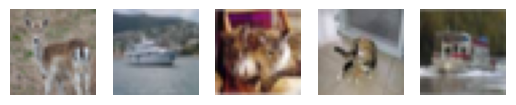

In [14]:
fig, axs = plt.subplots(1, 5)
for i in range(5):
  image, label = full_dataset[most_uncertain_indices[i]]
  image = image.squeeze().permute(1, 2, 0) / 2 + 0.5
  axs[i].imshow(image)
  axs[i].axis('off')

plt.show()

## Re-train model with new labeled images

In [15]:
init_indices.extend(most_uncertain_indices)
print(len(init_indices))

2200


In [16]:
labeled_set_2 = Subset(full_dataset, init_indices)
labeled_loader_2 = DataLoader(labeled_set, batch_size=64)

In [17]:
print(len(labeled_set_2))

2200


In [18]:
model_2 = Net(n_classes=len(classes))
model_2 = train(model_2, labeled_loader_2)

[1,    10] loss: 0.012
[1,    20] loss: 0.012
[1,    30] loss: 0.012
[2,    10] loss: 0.012
[2,    20] loss: 0.011
[2,    30] loss: 0.011
[3,    10] loss: 0.012
[3,    20] loss: 0.011
[3,    30] loss: 0.011
[4,    10] loss: 0.011
[4,    20] loss: 0.011
[4,    30] loss: 0.011
[5,    10] loss: 0.011
[5,    20] loss: 0.011
[5,    30] loss: 0.011
[6,    10] loss: 0.011
[6,    20] loss: 0.011
[6,    30] loss: 0.010
[7,    10] loss: 0.010
[7,    20] loss: 0.010
[7,    30] loss: 0.010
[8,    10] loss: 0.010
[8,    20] loss: 0.010
[8,    30] loss: 0.010
[9,    10] loss: 0.010
[9,    20] loss: 0.009
[9,    30] loss: 0.010
[10,    10] loss: 0.009
[10,    20] loss: 0.009
[10,    30] loss: 0.009
[11,    10] loss: 0.009
[11,    20] loss: 0.009
[11,    30] loss: 0.009
[12,    10] loss: 0.009
[12,    20] loss: 0.009
[12,    30] loss: 0.009
[13,    10] loss: 0.008
[13,    20] loss: 0.009
[13,    30] loss: 0.008
[14,    10] loss: 0.008
[14,    20] loss: 0.008
[14,    30] loss: 0.008
[15,    10] loss: 0

In [19]:
evaluate(model_2, test_set)

100%|██████████| 10000/10000 [00:11<00:00, 853.67it/s]


Accuracy of the model on the test images: 41.54 %


## Fine tune first model

In [22]:
model = train(model, labeled_loader_2)

[1,    10] loss: 0.000
[1,    20] loss: 0.000
[1,    30] loss: 0.000
[2,    10] loss: 0.000
[2,    20] loss: 0.000
[2,    30] loss: 0.000
[3,    10] loss: 0.000
[3,    20] loss: 0.000
[3,    30] loss: 0.000
[4,    10] loss: 0.000
[4,    20] loss: 0.000
[4,    30] loss: 0.000
[5,    10] loss: 0.000
[5,    20] loss: 0.000
[5,    30] loss: 0.000
[6,    10] loss: 0.000
[6,    20] loss: 0.000
[6,    30] loss: 0.000
[7,    10] loss: 0.000
[7,    20] loss: 0.000
[7,    30] loss: 0.000
[8,    10] loss: 0.000
[8,    20] loss: 0.000
[8,    30] loss: 0.000
[9,    10] loss: 0.000
[9,    20] loss: 0.000
[9,    30] loss: 0.000
[10,    10] loss: 0.000
[10,    20] loss: 0.000
[10,    30] loss: 0.000
[11,    10] loss: 0.000
[11,    20] loss: 0.000
[11,    30] loss: 0.000
[12,    10] loss: 0.000
[12,    20] loss: 0.000
[12,    30] loss: 0.000
[13,    10] loss: 0.000
[13,    20] loss: 0.000
[13,    30] loss: 0.000
[14,    10] loss: 0.000
[14,    20] loss: 0.000
[14,    30] loss: 0.000
[15,    10] loss: 0

In [23]:
evaluate(model, test_set)

100%|██████████| 10000/10000 [00:12<00:00, 787.59it/s]


Accuracy of the model on the test images: 40.84 %
